In [2]:
%matplotlib inline
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import numpy as np


import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'datashader'

## Processing MEA data
- Loading
- Removing the noisy channels 
- Assigning the anatomical labels to channels: (1) combing figures in ImageJ, (2) GUI with clicking + labels  
## ANALYSIS STREAM 1: 
    Spining Filtering
    Spike sorting 
    SUA and MUA activity 
    
## ANALYSIS STREAM 2: 
    LFP fintering 
    Automaic Event detection
    Manual Event validation 
    (1) Analysis in real space  -> event amplitudes, event types, event durations, etc
    (2) Analysis in time-frequency space -> Frequency composition
    
    
    


In [43]:
test_data_folder = r'/Volumes/Seagate Basic/R1648-export/28-10-24/slice4/' # adjust this!

In [44]:
names = ['2024-10-28T14-10-50slice1.h5',
            '2024-10-28T14-34-30slice1.h5',
            '2024-10-28T14-51-11slice1.h5'
]

channel_raw_data = McsPy.McsData.RawData(os.path.join(test_data_folder, 
                                                      names[2]))

In [45]:
channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
#.segment_streams[0]#.segment_entity[unit].info.label

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 3012000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">


In [46]:
print(channel_raw_data.recordings[0].analog_streams[0].channel_infos[2].info)

{'ChannelID': 2, 'RowIndex': 0, 'GroupID': 0, 'ElectrodeGroup': 0, 'Label': 'H16', 'RawDataType': 'Int', 'Unit': 'V', 'Exponent': -12, 'ADZero': 0, 'Tick': 100, 'ConversionFactor': 30711, 'ADCBits': 24, 'HighPassFilterType': '', 'HighPassFilterCutOffFrequency': '-1', 'HighPassFilterOrder': -1, 'LowPassFilterType': '', 'LowPassFilterCutOffFrequency': '-1', 'LowPassFilterOrder': -1}


In [47]:
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]

In [48]:
# channel_ids = list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)

In [49]:
# all should be the same
adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
#get offsets
offsets = [analog_stream_0.channel_infos[id_].get_field('ADZero') for id_ in channel_ids]

In [50]:
analog_stream_0_data = analog_stream_0.channel_data

In [51]:
# Get X and Y
fs = 10000 # 10KHz
x = np.arange(0,len(analog_stream_0_data[0,:]))/fs

In [52]:
na = np.array
y = na(analog_stream_0_data)
# correct to Volts
y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step

In [54]:
tsd = nap.TsdFrame(t=x, d=y.T,columns = np.arange(0,y.shape[0]))

In [55]:
import pynapple as nap
# Filter LFPs
data_band = nap.apply_bandpass_filter(tsd, cutoff=(.5, 200.0), fs=fs)
data =na(data_band)

In [56]:
import numpy as np

def find_and_merge_high_std_events(timeseries, std_threshold=5, min_length=100, merge_distance=100):
    # Calculate mean and standard deviation of the time series
    mean = np.mean(timeseries)
    std_dev = np.std(timeseries)
    
    # Define threshold for detecting events
    threshold = mean + std_threshold * std_dev
    
    # Find indices where the timeseries is above the threshold
    above_threshold = timeseries > threshold
    
    # Identify contiguous events
    events = []
    start_idx = None

    for i in range(len(above_threshold)):
        if above_threshold[i]:
            if start_idx is None:  # Start of a new event
                start_idx = i
        else:
            if start_idx is not None:  # End of an event
                if i - start_idx >= min_length:  # Check if event meets minimum length
                    events.append((start_idx, i-1))  # Append (start, end) indices of event
                start_idx = None  # Reset start index

    # Check if an event extends to the end of the series
    if start_idx is not None and len(timeseries) - start_idx >= min_length:
        events.append((start_idx, len(timeseries) - 1))

    # Merge events that are closer than merge_distance
    merged_events = []
    for event in events:
        if not merged_events or event[0] - merged_events[-1][1] > merge_distance:
            # No merging needed; add as a new event
            merged_events.append(event)
        else:
            # Merge with the previous event
            merged_events[-1] = (merged_events[-1][0], event[1])

    return merged_events

In [57]:
# Detect candidate events (5std)

#go per channel
channels = np.arange(0,data.shape[1])
evens_per_channel = []
for ch in channels:
    events = find_and_merge_high_std_events(data[:,ch], std_threshold=5, min_length=100)
    evens_per_channel.append(events)



In [58]:
active_channels = [len(e) for e in evens_per_channel]
indis = np.where(na(active_channels)>0)[0]

In [59]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure
def get_axes():
    fig, axs = plt.subplots(16, 16, figsize=(8, 8),dpi=200)
    letters = ['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
    # Set the labels for each subplot
    labels = [
        [f"{letters[j]}{i + 1}" for j in range(16)] for i in range(16)
    ]

    # Plot circles with text in each subplot
    ax_dict = {}
    for i in range(16):
        for j in range(16):
            ax = axs[i, j]
            ax.axis('off')
#             circle = patches.Circle((0.5, 0.5), radius=0.4,facecolor=[1,1,1],edgecolor='skyblue')#, color='skyblue')
#             ax.add_patch(circle)
            ax_dict[labels[i][j]] =ax
    return fig, ax_dict

<Figure size 720x360 with 0 Axes>

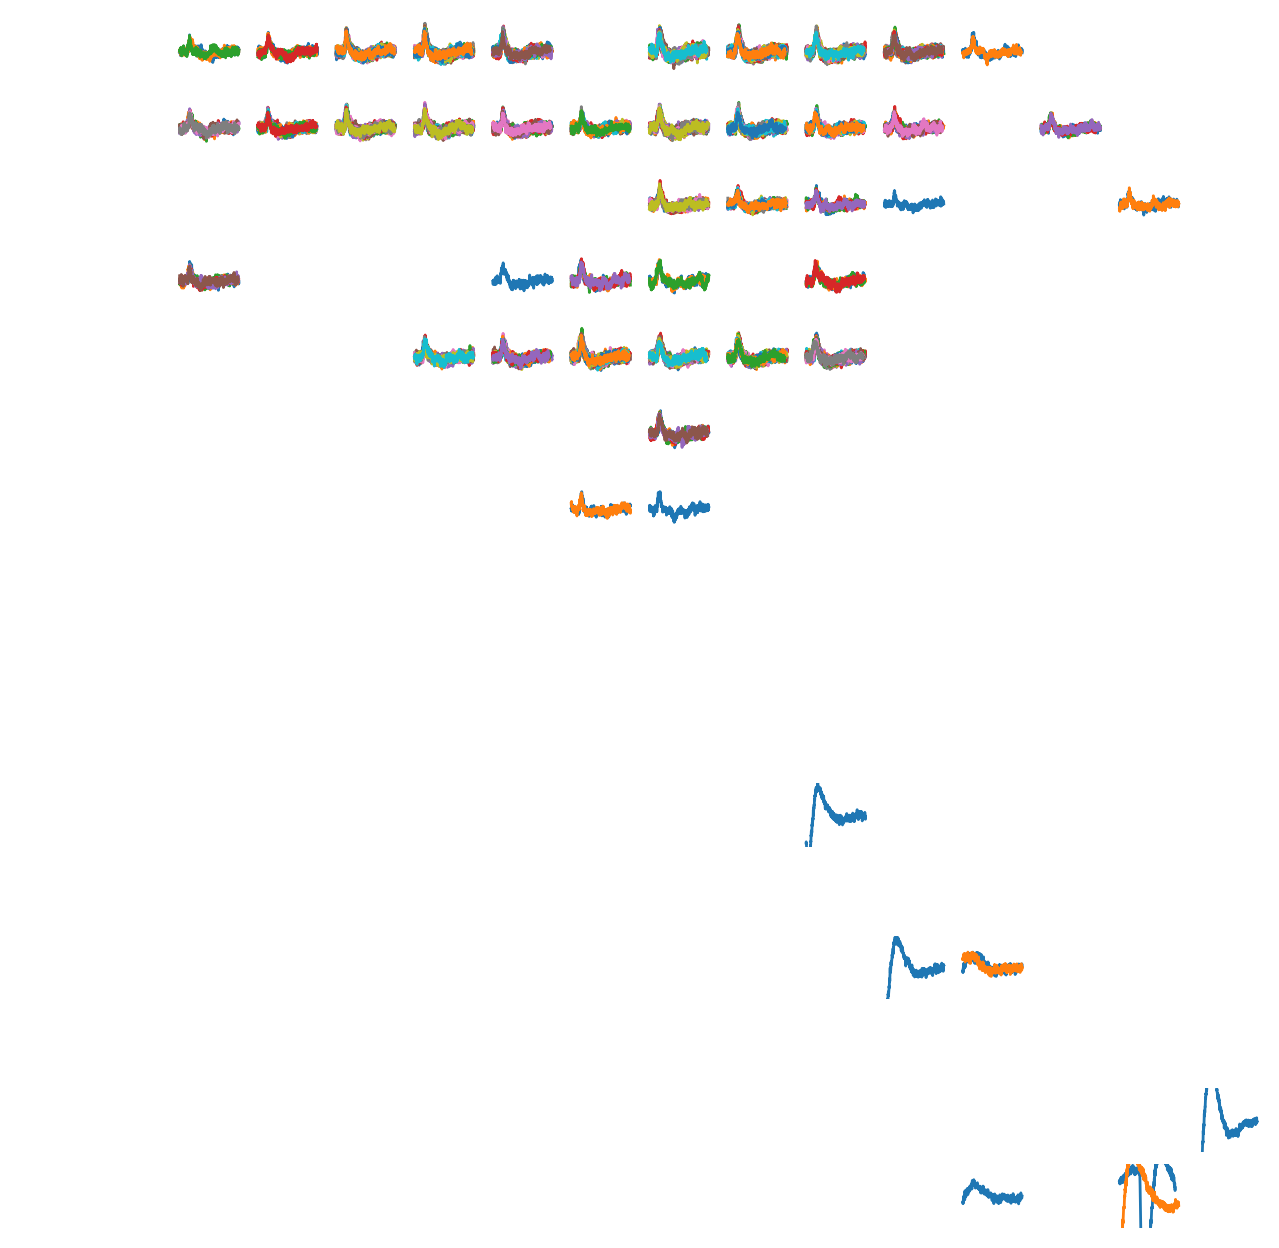

In [60]:
plt.figure(figsize=(10,5))
tmin,tmax = 400000,1000000
# for i in range(14):
# ch = indis[20]


# plt.figure(figsize=(10,10))
fig,ax = get_axes()

for n_ch,ch in enumerate(indis):
    events = evens_per_channel[ch]
#     plt.subplot(8,7,n_ch+1)
    # n = 2
    # event =events[n]
    for event in events:
    #     x[event[0]-1000:event[1]+1000],
        if event[0]>10001:
            label = channel_raw_data.recordings[0].analog_streams[0].channel_infos[ch].info['Label']
            time =np.arange(0,event[1]-event[0]+12000)*(1/fs)
            ax[label].plot(time, data[event[0]-2000:event[1]+10000,ch],lw=1.,alpha=1.);
        #     plt.plot(x[:],data[:,ch],'k',lw=1.,alpha=.1);
        #     plt.xlim(/fs,event[1]/fs)
        #     plt.plot(x[:1000],y[i,:1000]-1000*i,'k',lw=0.1,alpha=1.);
    #         plt.axis('off')
            ax[label].set_ylim(-0.00005,0.00005)
    #         ax[label].set_xlim(.5,1.5)
    
        
# plt.xlabel('Time(s)')
# plt.ylabel('uV')
# plt.show()
# plt.savefig('../figs/MEA1_LFP_3.pdf')

In [11]:
plt.show()